# Support Vector Machine and Fraud Detection

SVM is a supervised machine learning algorithm used for classification and regression tasks. It is highly effective in cases where data is high-dimensional and not easily separable.

SVM finds best possible boundary(decision boundary) that separates different classes in the dataset. Boundary is called hyperlane.
i) If the data is linearly separable, SVM finds a straight line or plane that best separates the classes.
ii) If the data is not linearly separable, SVM uses kernels to project data into higher dimensions where it becomes separable.

### SVC : Support Vector Classifier
Classification version of SVM

from sklearn.svc import SVC
model = SVC(kernel='linear')

It trains on labeled data and predicts which class a new samples belong to.
SVC is powerful when detecting anomalies, fraud, and rare cases.

### Kernel in SVM

When data cannot be separated by a straight line, kernel trick is used to map data into a higher dimensional space where separation is possible.

1. Linear Kernel - works well for linearly separable data, used when features have simple relationship.

2. Polynomial Kernel - used when there is some curvature in the data. The degree of the polynomial controls complexity

3. Radial Basis Function Kernel (kernel ='rbf)
Most widely used. Maps data into higher dimensional space, making it effective for complex datasets. Best for fraud detection where fraud and non-fraud transactions have no linear separation

4. Sigmoid - similar to neural network function.

### Why SVM for fraud detection?

1. Effective for imbalanced data - detecting rare fraudulent transactions
2. Works well in high-dimensional spaces - many features like amount, location, device.
3. Robust to outliers - fraud cases often appear as anomalies.

### Evaluation

Precision: How many of the predicted fraud cases were actually fraud?
Recall: How many actual fraud cases did we catch?
F1-Score: A balance between Precision & Recall.

In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE  # handle imbalanced data

Fraud
0    4873
1     127
Name: count, dtype: int64


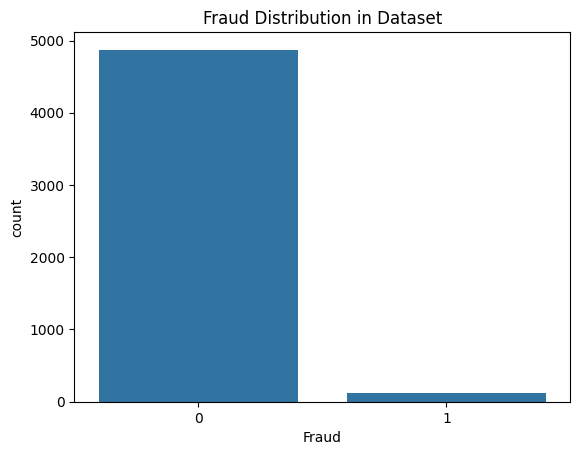

In [4]:
# Generate Synthetic Fraud detection data
# Since real fraud datasets are sensitive, we will simulate a dataset where fraulent transactions are rare, and normal transactions are common.
from sklearn.datasets import make_classification

# Generate dataset with imbalance
X, y = make_classification(n_samples=5000,  # 5000 transactions
                           n_features=20,   # 20 features
                           n_informative=10,  
                           n_redundant=5,  
                           weights=[0.98, 0.02],  # 98% legit, 2% fraud
                           random_state=42)

# Convert to DataFrame for better visualization
df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(20)])
df['Fraud'] = y  # Target variable

# Check fraud distribution
print(df['Fraud'].value_counts())

# Plot fraud vs non-fraud transactions
sns.countplot(x=df['Fraud'])
plt.title("Fraud Distribution in Dataset")
plt.show()


### SMOTE?

#### Summary
1. SMOTE - Generates synthetic minority examples by interpolation. Increases diversity, redueces overfitting risk compared to duplication. However, it may generate noisy samples if classes overlap too much.

2. Undersampling - Reduces majority class size. Simplifies dataset, faster training, loss of potentially useful information, risk of underfitting.

3. Weighting - Assigns higher misclassification costs to minority class samples. Does not modify data, forces model to consider minority class. Might lead to unstable training if weights are too high.


In [5]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Increase fraud cases to 50% of the majority
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Verify new class distribution
print(pd.Series(y_train_sm).value_counts())


0    3898
1    1949
Name: count, dtype: int64


In [6]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)


In [7]:
# Linear Kernel
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_sm, y_train_sm)

# RBF Kernel (Best for fraud detection)
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_sm, y_train_sm)

# Polynomial Kernel
svm_poly = SVC(kernel='poly', degree=3, probability=True, random_state=42)
svm_poly.fit(X_train_sm, y_train_sm)


SVC(kernel='poly', probability=True, random_state=42)

In [8]:
y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)
y_pred_poly = svm_poly.predict(X_test)


In [9]:
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"\n🔹 {model_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

# Evaluate all models
evaluate_model(y_test, y_pred_linear, "SVM (Linear Kernel)")
evaluate_model(y_test, y_pred_rbf, "SVM (RBF Kernel)")
evaluate_model(y_test, y_pred_poly, "SVM (Polynomial Kernel)")



🔹 SVM (Linear Kernel) Performance:
Accuracy: 0.94
Precision: 0.24
Recall: 0.68
F1 Score: 0.35
ROC-AUC: 0.81

🔹 SVM (RBF Kernel) Performance:
Accuracy: 0.98
Precision: 0.55
Recall: 0.44
F1 Score: 0.49
ROC-AUC: 0.72

🔹 SVM (Polynomial Kernel) Performance:
Accuracy: 0.97
Precision: 0.38
Recall: 0.52
F1 Score: 0.44
ROC-AUC: 0.75


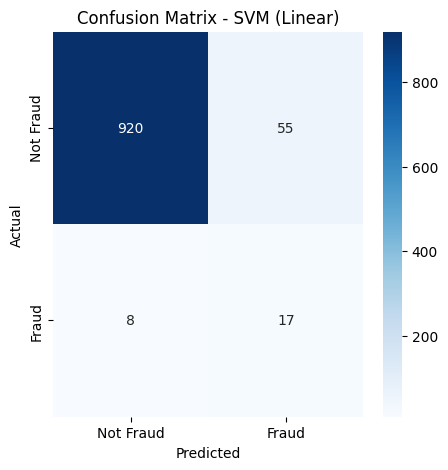

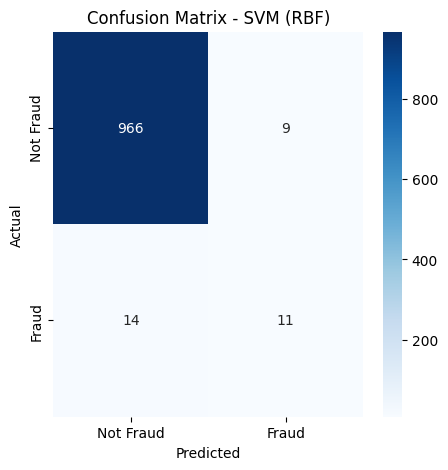

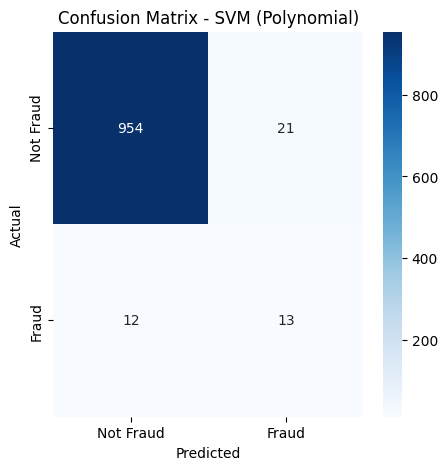

In [9]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_linear, "Confusion Matrix - SVM (Linear)")
plot_confusion_matrix(y_test, y_pred_rbf, "Confusion Matrix - SVM (RBF)")
plot_confusion_matrix(y_test, y_pred_poly, "Confusion Matrix - SVM (Polynomial)")


### Key Observations:

1. Linear SVM has the highest recall of 0.68 - This means it catches more fraudulent cases but at the cost of low precision.

2. RBF Kernel has the highest accuracy of 0.98 and precision 0.55 - It makes fewer mistakes in classifying fraud but misses some cases.

### Hyperparameter tuning for SVM (GridSearchCV)

1. C (Regularization parameter) controls how strict the margins is. How much to avoid misclassification.
2. Gamma (for RBF) controls how far a single data point influences the decision boundary.
3. Kernel choice impacts model flexibility.

### What is GridSearch CV?

GridSearchCV is a scikit-learn tool that exhaustively tests all possible combinations from a specified hyperparameter grid. It uses cross validation to evaluate each combination based on scoring metric

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a parameter grid: these are the values to try for each hyperparameter.
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization strength
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient for RBF
    'kernel': ['rbf']                  # We focus on the RBF kernel
}

# Create the SVM model.
# Note: We use class_weight='balanced' to help adjust for any imbalanced data.
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')

# Initialize GridSearchCV:
# - scoring='f1': We use the F1 score because it balances precision and recall.
# - cv=3: 3-fold cross-validation is used.
# - verbose=2: To print out progress information.
# - n_jobs=-1: Use all available cores for parallel processing.
grid_search = GridSearchCV(estimator=svm_model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Assume X_train and y_train are your training features and labels.
grid_search.fit(X_train, y_train)

# Extract the best parameters and model.
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


### Model Deployment

In [11]:
# Saving the trained model

import joblib

joblib.dump(best_model, r'C:\Users\lenovo\Desktop\MachineLearning\svm_best_model.pkl')
print("Model Saved as svm_bes_model.pkl")

Model Saved as svm_bes_model.pkl
